# **CLASSIFICATION OF GARBAGES USING FASTAI AND TRANSFER LEARNING**
### **TRASH TEAM**
#### Dataset used: TrashNet (https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip)

##### The dataset spans six classes: glass, paper, cardboard, plastic, metal, and trash. Currently, the dataset consists of 2527 images:

- 501 glass
- 594 paper
- 403 cardboard
- 482 plastic
- 410 metal
- 137 trash

The pictures were taken by placing the object on a white posterboard and using sunlight and/or room lighting. The pictures have been resized down to 512 x 384, 

#### Transfer Learning model used: ResNet152. 

In [1]:
# import necessary libraries
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from sklearn.metrics import confusion_matrix
from glob2 import glob
import pandas as pd
import numpy as np
import re
import os
import zipfile as zf
import shutil
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

## **1. Download and pre-process data**

In [3]:
#download the TrashNet dataset
!wget https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip

--2021-06-29 09:51:02--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2021-06-29 09:51:03--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M   223MB/s    in 0.2s    

2021-06-29 09:51:03 (223 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



In [4]:
#unzip the file and see what is inside
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['glass', 'paper', 'metal', '.DS_Store', 'plastic', 'cardboard', 'trash']

In [5]:
def split_dataset(folder,seed1,seed2):  
    '''
    This function is to split the dataset into Training (80%), Validation (10%), and Testing set (10%) 
    '''  
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.8*n))
    remain = list(set(full_set)-set(train))
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    return(train,valid,test)

def get_names(waste_type,indices):
    '''
    Get the name of the waste 
    '''
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [6]:
# UNCOMMENT THIS IF YOU ARE RUNNING THIS FOR THE FIRST TIME 
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_dataset(source_folder,1,1)
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)

    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    move_files(test_source_files,"data/test")

In [7]:
## apply transformations to data
path = Path(os.getcwd())/"data"
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]


In [8]:
data

ImageDataBunch;

Train: LabelList (2019 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Valid: LabelList (252 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/data;

Test: LabelList (256 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

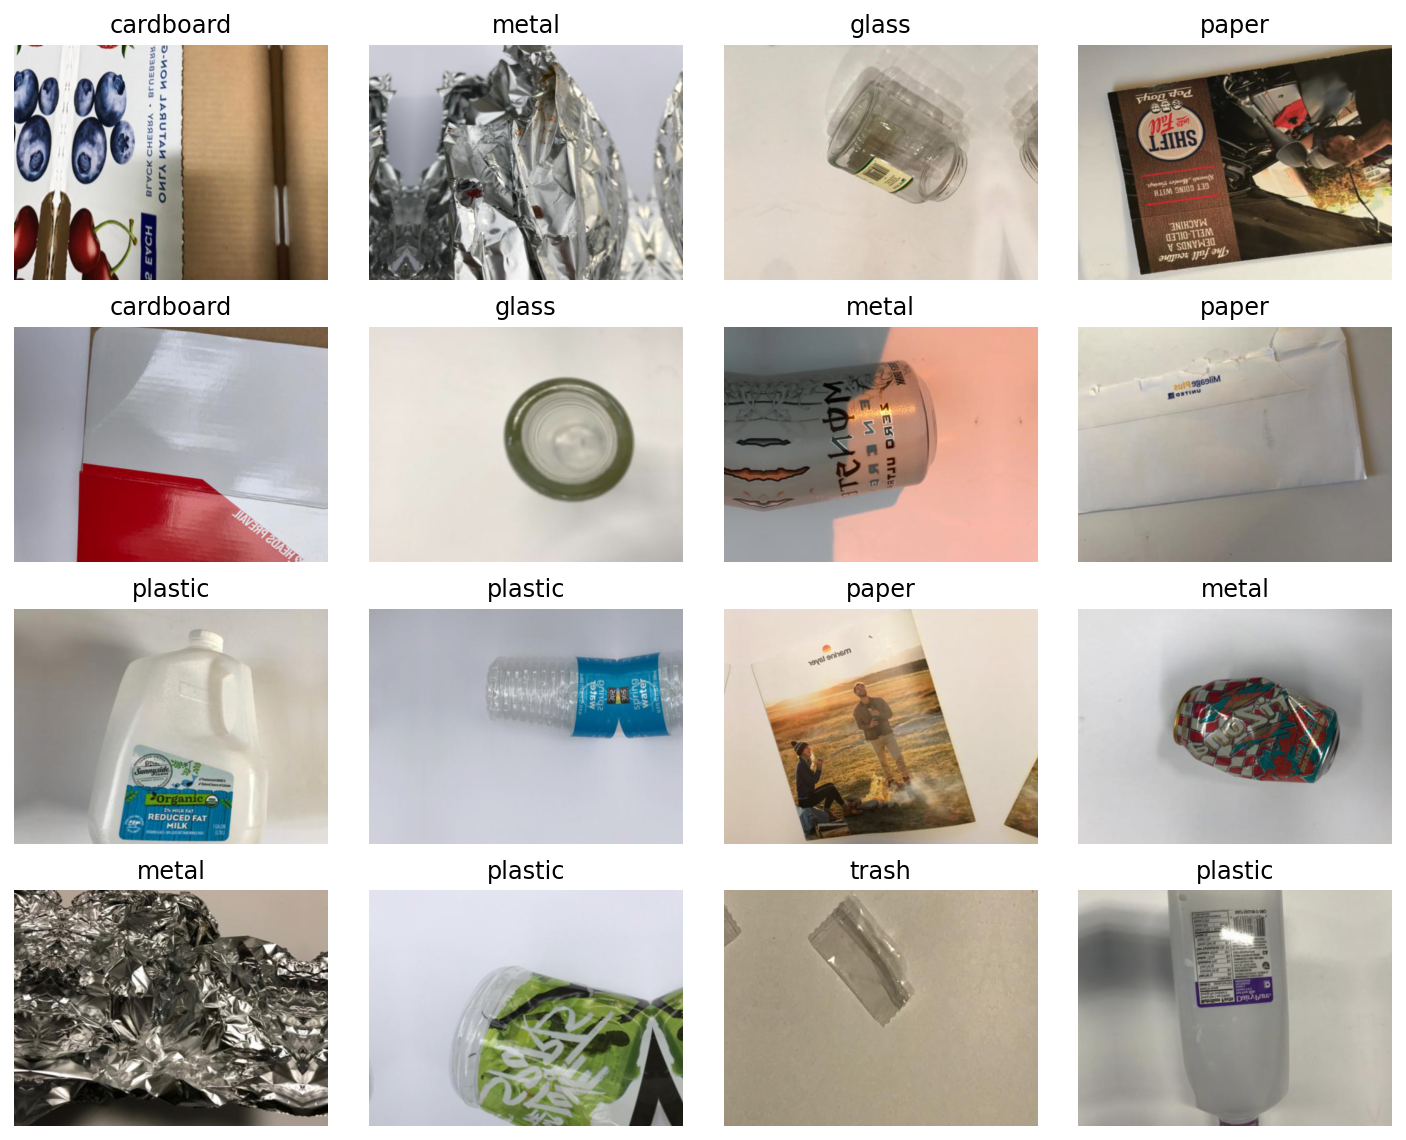

In [9]:
data.show_batch(rows=4,figsize=(10,8))

In [10]:
learn = create_cnn(data,models.resnet152,metrics=error_rate, callback_fns=ShowGraph)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.950413,0.382135,0.130952,02:10
1,0.816505,0.681496,0.174603,02:08
2,0.805705,1.717885,0.365079,02:08
3,0.775272,0.516113,0.190476,02:08
4,0.822443,0.791108,0.253968,02:08
5,0.792260,0.406830,0.134921,02:07
6,0.634191,0.745349,0.234127,02:07
7,0.546764,0.424999,0.154762,02:07
8,0.486976,0.386748,0.130952,02:07
9,0.366172,0.337871,0.130952,02:07


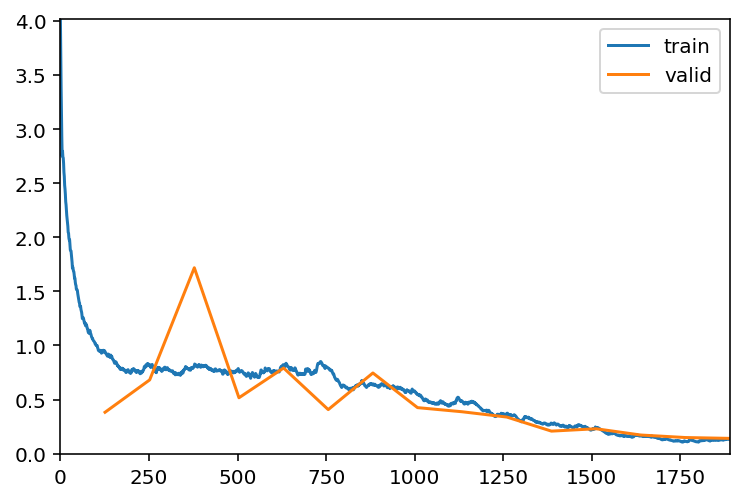

In [12]:
learn.fit_one_cycle(15,max_lr=5e-03)

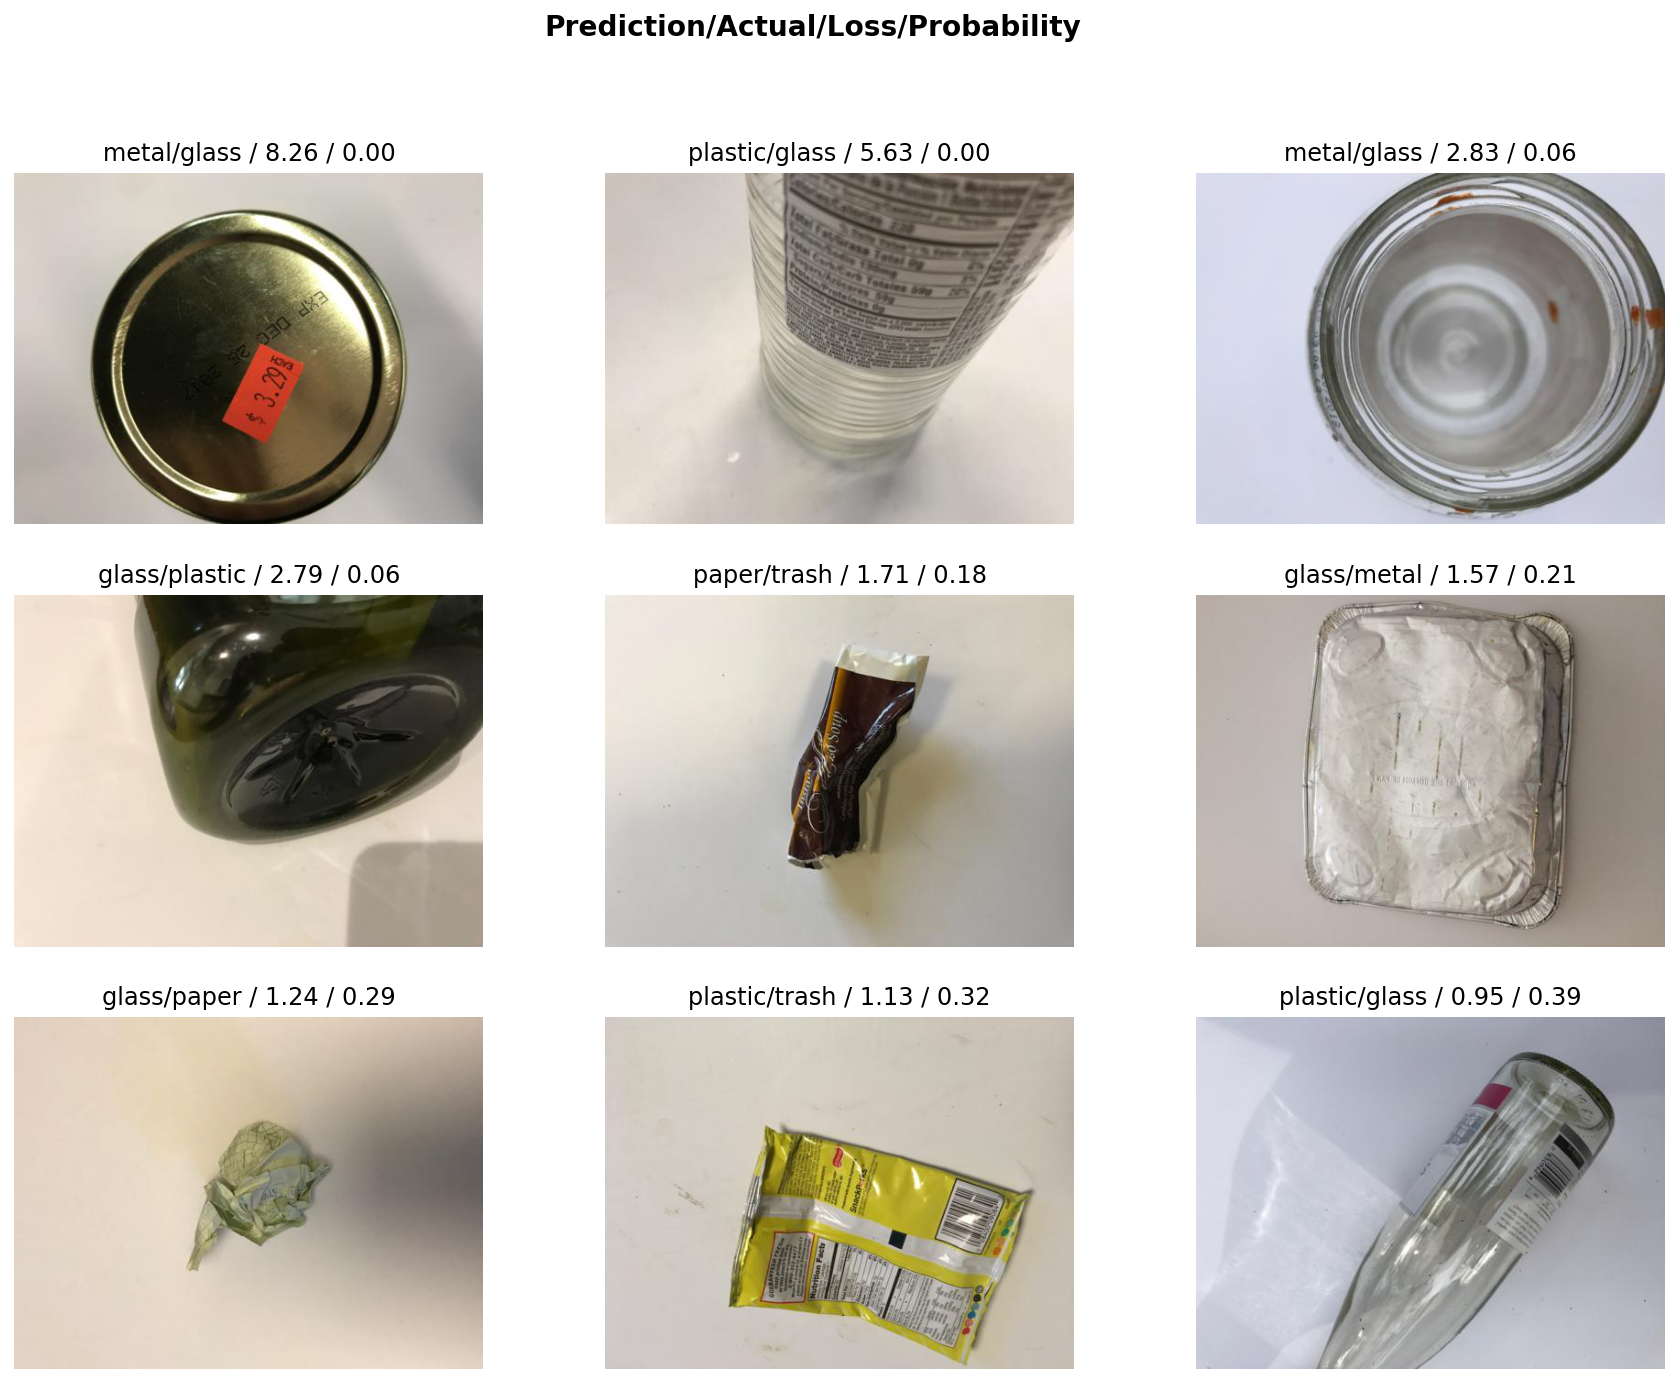

In [14]:
# print the top confused objects
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [16]:
interp.most_confused(min_val=2)

[('glass', 'plastic', 3), ('glass', 'metal', 2)]

In [17]:
preds = learn.get_preds(ds_type=DatasetType.Test)
print(preds[0].shape)
preds[0]

torch.Size([256, 6])


tensor([[9.9993e-01, 4.6177e-05, 1.4698e-06, 2.6376e-06, 2.0631e-05, 9.9446e-07],
        [1.3819e-04, 9.1348e-03, 7.9025e-01, 8.8204e-03, 3.7761e-03, 1.8788e-01],
        [1.8498e-08, 2.4105e-04, 8.9414e-06, 5.1263e-06, 9.9964e-01, 1.0179e-04],
        ...,
        [9.8670e-01, 1.4863e-03, 1.0280e-06, 1.1805e-02, 7.6263e-06, 4.4987e-07],
        [9.9998e-01, 3.3439e-07, 1.0081e-08, 1.7067e-05, 5.6014e-07, 6.0754e-06],
        [2.2655e-04, 9.8850e-01, 1.1036e-02, 3.4196e-05, 1.8507e-04, 2.1557e-05]])

In [20]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))
class_predicted = []
for id in max_idxs:
    class_predicted.append(data.classes[id])

class_predicted 

['cardboard',
 'metal',
 'plastic',
 'plastic',
 'trash',
 'paper',
 'glass',
 'paper',
 'metal',
 'paper',
 'glass',
 'metal',
 'metal',
 'cardboard',
 'cardboard',
 'glass',
 'paper',
 'trash',
 'plastic',
 'cardboard',
 'glass',
 'metal',
 'paper',
 'paper',
 'glass',
 'metal',
 'plastic',
 'plastic',
 'plastic',
 'paper',
 'plastic',
 'plastic',
 'trash',
 'paper',
 'glass',
 'paper',
 'metal',
 'glass',
 'metal',
 'metal',
 'glass',
 'trash',
 'paper',
 'metal',
 'metal',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'metal',
 'glass',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'plastic',
 'plastic',
 'metal',
 'cardboard',
 'paper',
 'metal',
 'glass',
 'paper',
 'paper',
 'metal',
 'cardboard',
 'cardboard',
 'metal',
 'paper',
 'glass',
 'plastic',
 'trash',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'plastic',
 'metal',
 'plastic',
 'cardboard',
 'metal',
 'paper',
 'paper',
 'metal',
 'cardboard',
 'glass',
 'glass',
 'paper',
 'plastic',
 'plastic',
 'paper',
 'me

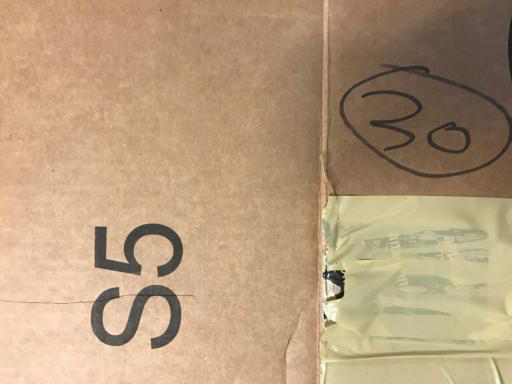

In [21]:
learn.data.test_ds[0][0]

In [22]:
waste_ = []

for label_path in data.test_ds.items:
    waste_.append(str(label_path))
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(waste_)):
    waste_[i] = pattern.search(waste_[i]).group(1)

In [23]:
## predicted values
print(class_predicted[0:5])
## actual values
print(waste_[0:5])

['cardboard', 'metal', 'plastic', 'plastic', 'trash']
['cardboard', 'metal', 'plastic', 'plastic', 'trash']


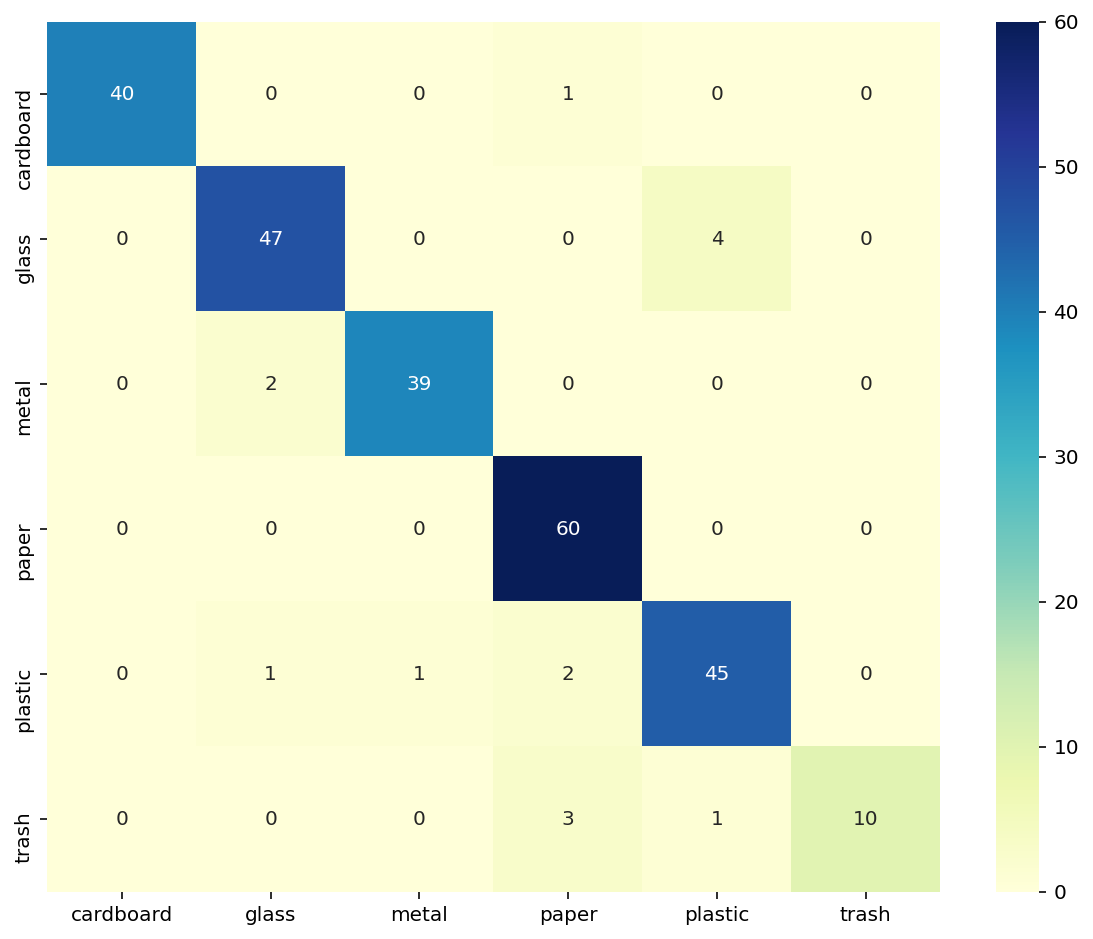

In [25]:
# print the confusion matrix 
cm = confusion_matrix(waste_,class_predicted)
df_cm = pd.DataFrame(cm,waste_types,waste_types)
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [27]:
# cal the accuracy 
TP = 0
for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            TP += cm[r,c]

accuracy = TP/sum(sum(cm))
accuracy

0.94140625